In [30]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [31]:
class LSQ(torch.autograd.Function):
    
    #METHOD
    @staticmethod
    def forward(ctx, v, s, Qn, Qp):
        ctx.save_for_backward(v, s)
        ctx.other = Qn, Qp
        
        q_int = (v/s).round().clamp(Qn, Qp)
        
        return q_int*s
    
    #STEP SIZE GRADIENT
    @staticmethod
    def backward(ctx, grad_output):
        v, s = ctx.saved_tensors
        Qn, Qp = ctx.other  
        q_int = (v/s).clamp(Qn, Qp)
        
        if q_int == Qn or q_int==Qp:
            return grad_output, q_int, None, None, None
        
        return grad_output, -v/s+q_int.round(), None, None, None

In [32]:
Qn = 0
Qp = 3

In [33]:
weights = []
weights_q = []
s_grads = []
    
for i in range(0,400):
    weight = Variable(torch.Tensor([i * 0.01]), requires_grad=True)
    weights.append(weight.data[0])
    
    s = torch.ones(1, requires_grad=True)
    weight_q = LSQ.apply(weight, s, Qn, Qp)
    weights_q.append(weight_q.data[0])
    weight_q.backward(retain_graph=True)
    s_grads.append(s.grad)

In [34]:
#print(weights)

In [35]:
#print(weights_q)

In [36]:
#print(s_grads)

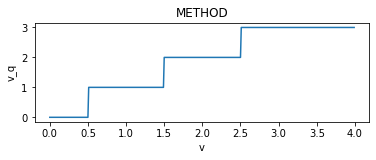

In [37]:
plt.subplot(2,1,1)
plt.plot(weights, weights_q)
plt.title('METHOD')
plt.ylabel('v_q')
plt.xlabel('v')

plt.show()

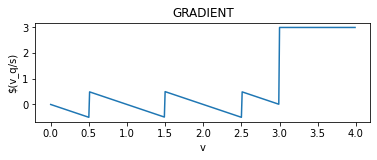

In [38]:
plt.subplot(2,1,1)
plt.plot(weights, s_grads)
plt.title('GRADIENT')
plt.ylabel('$(v_q/s)')
plt.xlabel('v')
plt.show()

# TRAIN DATA WITH LSQ

## 1. Define a Convolutional Neuron Network

In [40]:
import torch.nn as nn
import torch.nn.functional as F

In [41]:
#Network for CIFAR10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Implement nn.Conv2d (weight), nn.Linear (activation) with LSQ???